# Qura Question Pairs

## Importing some Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization,Embedding
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import nltk

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Downloading the dataset

In [3]:
!wget http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv

--2023-06-02 14:14:45--  http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv
Resolving qim.fs.quoracdn.net (qim.fs.quoracdn.net)... 162.159.152.17, 162.159.153.247
Connecting to qim.fs.quoracdn.net (qim.fs.quoracdn.net)|162.159.152.17|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://qim.fs.quoracdn.net/quora_duplicate_questions.tsv [following]
--2023-06-02 14:14:45--  https://qim.fs.quoracdn.net/quora_duplicate_questions.tsv
Connecting to qim.fs.quoracdn.net (qim.fs.quoracdn.net)|162.159.152.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58176133 (55M) [text/tab-separated-values]
Saving to: ‘quora_duplicate_questions.tsv’

quora_duplicate_que 100%[===================>]  55.48M   348MB/s    in 0.2s    

2023-06-02 14:14:45 (348 MB/s) - ‘quora_duplicate_questions.tsv’ saved [58176133/58176133]



In [4]:
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip

--2023-06-02 14:14:45--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip
Resolving huggingface.co (huggingface.co)... 18.155.68.44, 18.155.68.121, 18.155.68.38, ...
Connecting to huggingface.co (huggingface.co)|18.155.68.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/357baac33090f645e71e253b3295ee1b767c98a0336e9a1d99c77e9e33b43c4a?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27glove.42B.300d.zip%3B+filename%3D%22glove.42B.300d.zip%22%3B&response-content-type=application%2Fzip&Expires=1685973161&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3N0YW5mb3JkbmxwL2dsb3ZlLzM1N2JhYWMzMzA5MGY2NDVlNzFlMjUzYjMyOTVlZTFiNzY3Yzk4YTAzMzZlOWExZDk5Yzc3ZTllMzNiNDNjNGE%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qJnJlc3BvbnNlLWNvbnRlbnQtdHlwZT0qIiwiQ29uZGl0aW9uIjp7IkRhdGVMZXNzVGhhbiI6eyJBV1M6RXBvY2hUaW1lIjoxNjg1OTczMTYxfX19XX0_&Signature=qmcufqO6

### Loading the dataset

In [5]:
data=pd.read_csv('/content/quora_duplicate_questions.tsv',delimiter='\t')

## Importing some helper functions

In [6]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-02 14:16:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-02 14:16:47 (60.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [7]:
from helper_functions import unzip_data,walk_through_dir

In [8]:
unzip_data('/content/glove.42B.300d.zip')

## Exploring the dataset

In [9]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [10]:
data.tail()

,id,qid1,qid2,question1,question2,is_duplicate
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0
404289,404289,537932,537933,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


In [11]:
data['is_duplicate'].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [12]:
data.shape

(404290, 6)

In [13]:
data.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [14]:
data=data.dropna()

In [15]:
data.isna().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [16]:
question1=data['question1']
len_q1=[len(x.split()) for x in question1]

In [17]:
question2=data['question2']
len_q2=[len(x.split()) for x in question2]

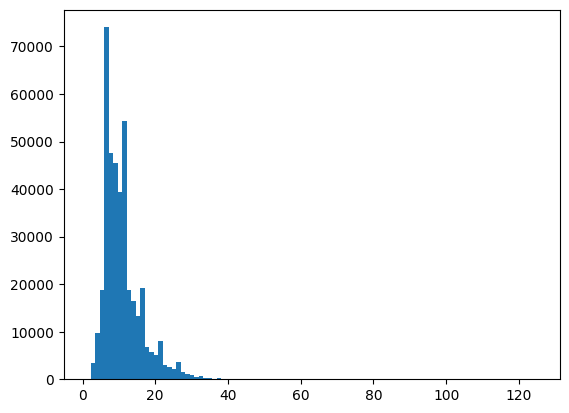

In [18]:
plt.hist(len_q1,bins=100);

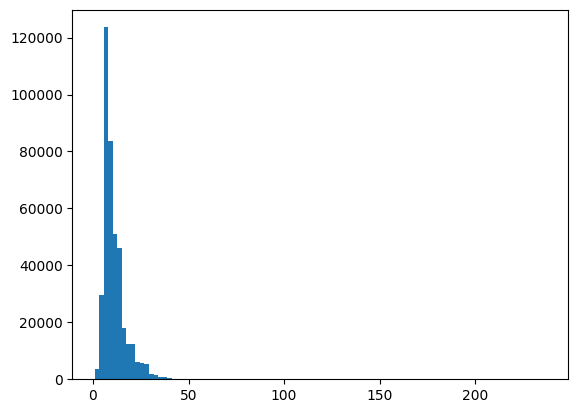

In [19]:
plt.hist(len_q2,bins=100);

In [20]:
max_len_q1=np.percentile(len_q1,99)
max_len_q1

29.0

In [21]:
max_len_q2=np.percentile(len_q2,99)
max_len_q2

33.0

## Data cleaning functions

In [22]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [23]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")]) 
    newString = re.sub("[^a-zA-Z]", " ", newString)
    return ' '.join(newString.split())

def remove_stopwords(text):
    tokens = [w for w in text.split() if not w in stop_words]  
    return (" ".join(tokens)).strip()

In [24]:
text_cleaner("I'm a student at the University of Toronto.")

'i am a student at the university of toronto'

In [25]:
q1_sentences=data['question1'].apply(text_cleaner)

<ipython-input-23-b197a37aac6b>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  newString = BeautifulSoup(newString, "lxml").text


In [26]:
q2_sentences=data['question2'].apply(text_cleaner)

<ipython-input-23-b197a37aac6b>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  newString = BeautifulSoup(newString, "lxml").text


## Creating new dataframe

In [27]:
labels=data['is_duplicate']
cleaned_data=pd.DataFrame([q1_sentences,q2_sentences,labels]).transpose()

## Checking Average sentence length after cleaning

In [28]:
len_q1=[len(x.split()) for x in q1_sentences]
len_q2=[len(x.split()) for x in q2_sentences]

In [29]:
max_len_q2=int(np.percentile(len_q2,99))
max_len_q2

33

In [30]:
max_len_q1=int(np.percentile(len_q1,99))
max_len_q1=max_len_q2

In [31]:
max_len_q1

33

## Creating Char based Data

In [32]:
def split_chars(text):
  return ' '.join(list(text))

In [33]:
chars_q1=[split_chars(sentence) for sentence in q1_sentences]

In [34]:
chars_q2=[split_chars(sentence) for sentence in q2_sentences]

## Splitting dataset

In [35]:
cleaned_data['charq1']=chars_q1
cleaned_data['charq2']=chars_q2

In [36]:
from sklearn.model_selection import train_test_split
xtrain, xmid, ytrain, ymid = train_test_split(cleaned_data.drop('is_duplicate',axis=1),
                                                    cleaned_data['is_duplicate'],
                                                    test_size=0.15, random_state=42)
xval, xtest, yval, ytest = train_test_split(xmid,ymid,test_size=0.50, random_state=42)

# Preparing for Deep sequence modelling

In [37]:
from tensorflow.keras.layers import TextVectorization,Embedding
import tensorflow as tf

## Character level tokenizer and embeddings

### Character level tokenizer for Q1

In [38]:
char_len_q1=[len(sentence) for sentence in xtrain['question1']]
mean_char_len_q1=np.mean(char_len_q1)
mean_char_len_q1

57.60245370922731

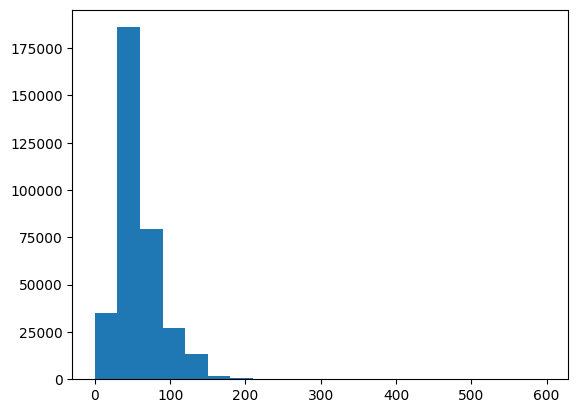

In [39]:
# check distribution

import matplotlib.pyplot as plt

plt.hist(char_len_q1,bins=20);

In [40]:
#find what character length covers 98% of sequences
output_seq_char_len_q1=int(np.percentile(char_len_q1,98))

In [41]:
output_seq_char_len_q1

140

In [42]:
#number of alphanumeric characters
import string
alphabet=string.ascii_lowercase

In [43]:
num_char_tokens_q1=len(alphabet) + 10 # add for space and UNK

In [44]:
char_vectorizer_q1=TextVectorization(max_tokens=num_char_tokens_q1,
                                  output_sequence_length=144,
                                  name='char_vectorizer_q1')

In [45]:
char_vectorizer_q1.adapt(xtrain['charq1'])

In [46]:
#check character vocab stats
char_vocab_q1=char_vectorizer_q1.get_vocabulary()

### Character level tokenizer for Q2

In [47]:
char_len_q2=[len(sentence) for sentence in xtrain['question2']]
mean_char_len_q2=np.mean(char_len_q2)
mean_char_len_q2

58.12881391444028

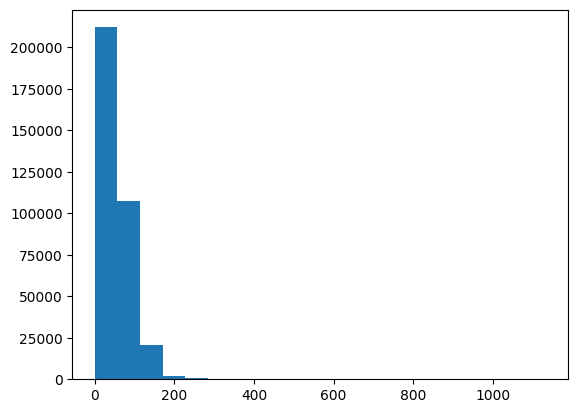

In [48]:
# check distribution

import matplotlib.pyplot as plt

plt.hist(char_len_q2,bins=20);

In [49]:
#find what character length covers 95% of sequences
output_seq_char_len_q2=int(np.percentile(char_len_q2,98))
output_seq_char_len_q2

144

In [50]:
num_char_tokens_q2=len(alphabet) + 10 # add for space and UNK

In [51]:
#number of alphanumeric characters
import string
alphabet=string.ascii_lowercase

In [52]:
char_vectorizer_q2=TextVectorization(max_tokens=num_char_tokens_q2,
                                  output_sequence_length=output_seq_char_len_q2,
                                  name='char_vectorizer_q2')

In [53]:
char_vectorizer_q2.adapt(xtrain['charq2'])

In [54]:
#check character vocab stats
char_vocab_q2=char_vectorizer_q2.get_vocabulary()

### Character level Embedding Q1

In [55]:
output_dim=96
#input_dims=Vocab length
#mask_zero saves space by masking 0 values out with are padding
char_embedding_q1=Embedding(input_dim=len(char_vocab_q1),
                         output_dim=output_dim,
                         mask_zero=True,
                         name='char_embedding_q1')

### Character level Embedding Q2

In [56]:
output_dim=96
#input_dims=Vocab length
#mask_zero saves space by masking 0 values out with are padding
char_embedding_q2=Embedding(input_dim=len(char_vocab_q2),
                         output_dim=output_dim,
                         mask_zero=True,
                         name='char_embedding_q2')

## Token Text Vectorization

### Q1 vectorizer

In [57]:
#Text vectorization layer
# Output_sequence_length= length of output sentence
max_tokens=80000
q1_text_vectorizer=TextVectorization(max_tokens=max_tokens,
                                  split='whitespace',
                                  output_sequence_length=max_len_q1)

In [58]:
#Adapt text vectorizer to training sentences
q1_text_vectorizer.adapt(xtrain['question1'])

In [59]:
q1_vectorizer_vocab_token=q1_text_vectorizer.get_vocabulary()

In [60]:
len(q1_vectorizer_vocab_token)

59046

### Q2 vectorizer

In [61]:
#Text vectorization layer
# Output_sequence_length= length of output sentence
max_tokens=80000
q2_text_vectorizer=TextVectorization(max_tokens=max_tokens,
                                  split='whitespace',
                                  output_sequence_length=max_len_q2)

In [62]:
#Adapt text vectorizer to training sentences
q2_text_vectorizer.adapt(xtrain['question2'])

In [63]:
q2_vectorizer_vocab_token=q2_text_vectorizer.get_vocabulary()
len(q2_vectorizer_vocab_token)

54387

## Token Embedding layer

In [64]:
glove_file = 'glove.42B.300d.txt'
embeddings_index = {}
with open(glove_file, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

### Q1 Embedding

In [65]:
word_index_q1 = dict(zip(q1_text_vectorizer.get_vocabulary(), range(len(q1_text_vectorizer.get_vocabulary()))))

In [66]:
# Create the embedding matrix
embedding_dim = 300
num_words = len(word_index_q1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index_q1.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [67]:
output_dim=300
#input_dims=Vocab length
q1_embedding=Embedding(input_dim=len(q1_vectorizer_vocab_token),output_dim=output_dim,
                       embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                       trainable=False,name='q1_token_embedding')

### Q2 Embedding

In [68]:
word_index_q2 = dict(zip(q2_text_vectorizer.get_vocabulary(), range(len(q2_text_vectorizer.get_vocabulary()))))

In [69]:
# Create the embedding matrix
embedding_dim = 300
num_words = len(word_index_q2)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index_q2.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [70]:
embedding_matrix.shape

(54387, 300)

In [71]:
len(q2_vectorizer_vocab_token)

54387

In [72]:
output_dim=300 
#input_dims=Vocab length
q2_embedding=Embedding(input_dim=len(q2_vectorizer_vocab_token),output_dim=output_dim,
                       embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                       trainable=False,name='q2_token_embedding')

## Modelling 

### Model1: Char Model:

#### Creating dataset

In [ ]:
train_char_data=tf.data.Dataset.from_tensor_slices((xtrain['charq1'].values,
                                               xtrain['charq2'].values))
train_char_labels=tf.data.Dataset.from_tensor_slices(ytrain.apply(pd.to_numeric).values)
train_char_dataset=tf.data.Dataset.zip((train_char_data,train_char_labels))
train_char_dataset=train_char_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)



val_char_data=tf.data.Dataset.from_tensor_slices((xval['charq1'].values,
                                             xval['charq2'].values))
val_char_labels=tf.data.Dataset.from_tensor_slices(yval.apply(pd.to_numeric).values)
val_char_dataset=tf.data.Dataset.zip((val_char_data,val_char_labels))
val_char_dataset=val_char_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)



test_char_data=tf.data.Dataset.from_tensor_slices((xtest['charq1'].values,
                                              xtest['charq2'].values))
test_char_labels=tf.data.Dataset.from_tensor_slices(ytest.apply(pd.to_numeric).values)
test_char_dataset=tf.data.Dataset.zip((test_char_data,test_char_labels))
test_char_dataset=test_char_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

#### Model

In [ ]:
q1_char_inputs=tf.keras.layers.Input(shape=(1,),dtype=tf.string)
q1_char_preprocessor=char_vectorizer_q1(q1_char_inputs)
q1_char_embed=char_embedding_q1(q1_char_preprocessor)
q1_char_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))(q1_char_embed)
q1_char_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh',return_sequences=True))(q1_char_gru1)
q1_char_model=tf.keras.Model(q1_char_inputs,q1_char_gru2)


q2_char_inputs=tf.keras.layers.Input(shape=(1,),dtype=tf.string)
q2_char_preprocessor=char_vectorizer_q2(q2_char_inputs)
q2_char_embed=char_embedding_q2(q2_char_preprocessor)
q2_char_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))(q2_char_embed)
q2_char_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh',return_sequences=True))(q2_char_gru1)
q2_char_model=tf.keras.Model(q2_char_inputs,q2_char_gru2)

q1_q2_char_concat=tf.keras.layers.Concatenate()([q1_char_model.output,
                               q2_char_model.output])

combined_char_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))(q1_q2_char_concat)
combined_char_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh',return_sequences=True))(combined_char_gru1)
combined_char_gru3=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh'))(combined_char_gru2)

output=tf.keras.layers.Dense(1,activation='sigmoid')(combined_char_gru3)

model1=tf.keras.Model(inputs=[q1_char_model.input,q2_char_model.input],
                      outputs=output,
                      name='Model1')

In [ ]:
model1.summary()

Model: "Model1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 char_vectorizer_q1 (TextVector  (None, 144)         0           ['input_5[0][0]']                
 ization)                                                                                         
                                                                                                  
 char_vectorizer_q2 (TextVector  (None, 144)         0           ['input_6[0][0]']           

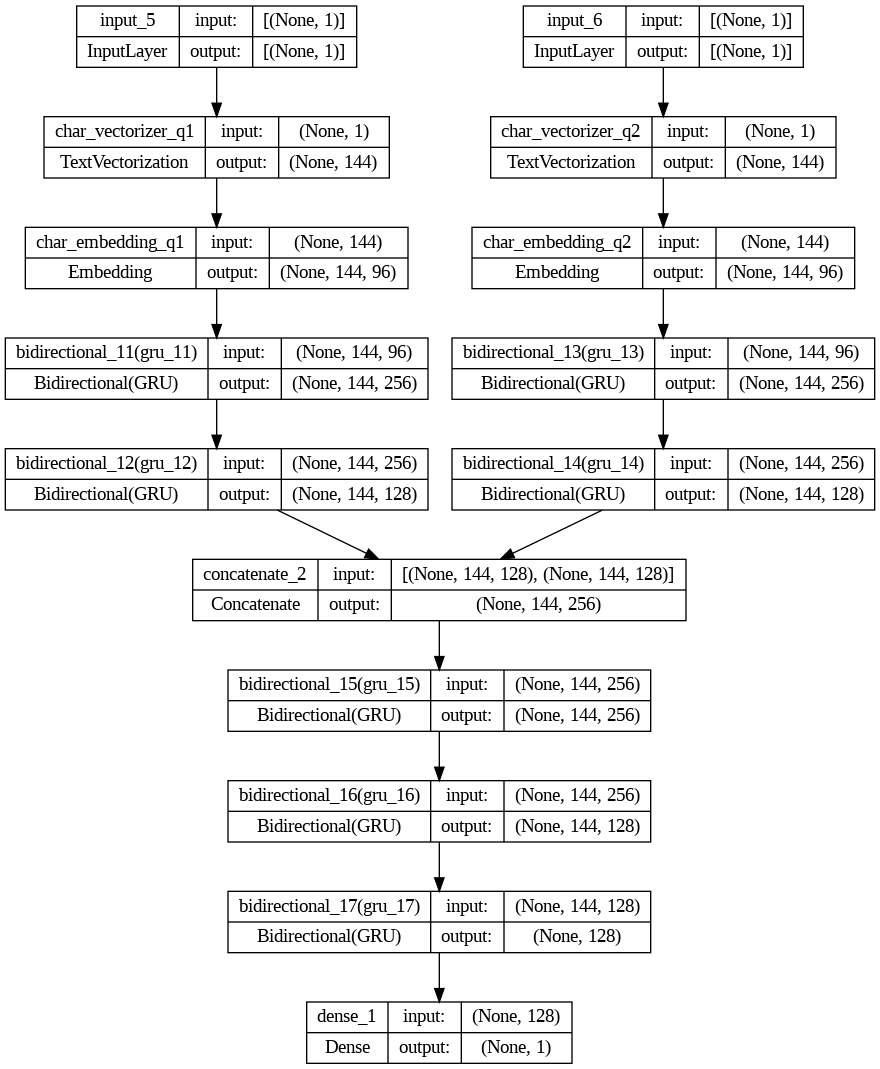

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model1,show_shapes=True)

In [ ]:
model1.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.2),
               optimizer=tf.keras.optimizers.Adam(lr=0.001),
               metrics=['accuracy'])

In [ ]:
history1=model1.fit(train_char_dataset,
                    epochs=5,
                    steps_per_epoch=int(0.2*len(train_char_dataset)),
                    validation_data=val_char_dataset,
                    validation_steps=int(0.2*len(val_char_dataset)))

Epoch 1/5
1895/1895 [==============================] - 247s 130ms/step - loss: 0.5974 - accuracy: 0.7264 - val_loss: 0.5971 - val_accuracy: 0.7264
Epoch 2/5
1895/1895 [==============================] - 227s 120ms/step - loss: 0.5890 - accuracy: 0.7390 - val_loss: 0.5839 - val_accuracy: 0.7480
Epoch 3/5
1895/1895 [==============================] - 225s 119ms/step - loss: 0.5833 - accuracy: 0.7462 - val_loss: 0.5826 - val_accuracy: 0.7465
Epoch 4/5
1895/1895 [==============================] - 232s 122ms/step - loss: 0.5801 - accuracy: 0.7492 - val_loss: 0.5791 - val_accuracy: 0.7509
Epoch 5/5
1895/1895 [==============================] - 229s 121ms/step - loss: 0.5752 - accuracy: 0.7550 - val_loss: 0.5827 - val_accuracy: 0.7477


### Model 2: Token GRUs with attention

#### Creating dataset

In [73]:
train_token_data=tf.data.Dataset.from_tensor_slices((xtrain['question1'].values,
                                               xtrain['question2'].values))
train_token_labels=tf.data.Dataset.from_tensor_slices(ytrain.apply(pd.to_numeric).values)
train_token_dataset=tf.data.Dataset.zip((train_token_data,train_token_labels))
train_token_dataset=train_token_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)



val_token_data=tf.data.Dataset.from_tensor_slices((xval['question1'].values,
                                               xval['question2'].values))
val_token_labels=tf.data.Dataset.from_tensor_slices(yval.apply(pd.to_numeric).values)
val_token_dataset=tf.data.Dataset.zip((val_token_data,val_token_labels))
val_token_dataset=val_token_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)



test_token_data=tf.data.Dataset.from_tensor_slices((xtest['question1'].values,
                                               xtest['question2'].values))
test_token_labels=tf.data.Dataset.from_tensor_slices(ytest.apply(pd.to_numeric).values)
test_token_dataset=tf.data.Dataset.zip((test_token_data,test_token_labels))
test_token_dataset=test_token_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

#### Model

In [74]:
q1_token_inputs=tf.keras.layers.Input(shape=(),dtype=tf.string)
q1_preprocessor=q1_text_vectorizer(q1_token_inputs)
q1_embed=q1_embedding(q1_preprocessor)


q2_token_inputs=tf.keras.layers.Input(shape=(),dtype=tf.string)
q2_preprocessor=q2_text_vectorizer(q2_token_inputs)
q2_embed=q2_embedding(q2_preprocessor)

dot_product_embed = tf.keras.layers.Dot(axes=2)([q1_embed, q2_embed])
attention_weights_q1_embed = tf.keras.layers.Softmax()(dot_product_embed)
q1_weighted_embed = tf.keras.layers.Dot(axes=1)([attention_weights_q1_embed, q1_embed])

attention_weights_q2_embed = tf.keras.layers.Softmax()(dot_product_embed)
q2_weighted_embed = tf.keras.layers.Dot(axes=1)([attention_weights_q2_embed, q2_embed])


q1_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))(q1_weighted_embed)
q1_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh',return_sequences=True))(q1_gru1)
q2_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))(q2_weighted_embed)
q2_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh',return_sequences=True))(q2_gru1)

dot_product = tf.keras.layers.Dot(axes=2)([q2_gru2, q1_gru2])
attention_weights_q1 = tf.keras.layers.Softmax()(dot_product)
attention_weights_q2 = tf.keras.layers.Softmax()(dot_product)

q1_weighted = tf.keras.layers.Dot(axes=1)([attention_weights_q1, q1_gru2])
q2_weighted = tf.keras.layers.Dot(axes=1)([attention_weights_q2, q2_gru2])

q1_q2_token_concat=tf.keras.layers.Concatenate()([q2_weighted,
                               q1_weighted])

combined_token_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))(q1_q2_token_concat)
combined_token_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh',return_sequences=True))(combined_token_gru1)
combined_token_gru3=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh'))(combined_token_gru2)


combined_dense1=tf.keras.layers.Dense(64,activation='relu')(combined_token_gru3)
output=tf.keras.layers.Dense(1,activation='sigmoid')(combined_dense1)

model2=tf.keras.Model(inputs=[q1_token_inputs,q2_token_inputs],
                      outputs=output,
                      name='Model2')

In [75]:
model2.summary()

Model: "Model2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 33)          0           ['input_1[0][0]']                
 ization)                                                                                         
                                                                                                  
 text_vectorization_1 (TextVect  (None, 33)          0           ['input_2[0][0]']           

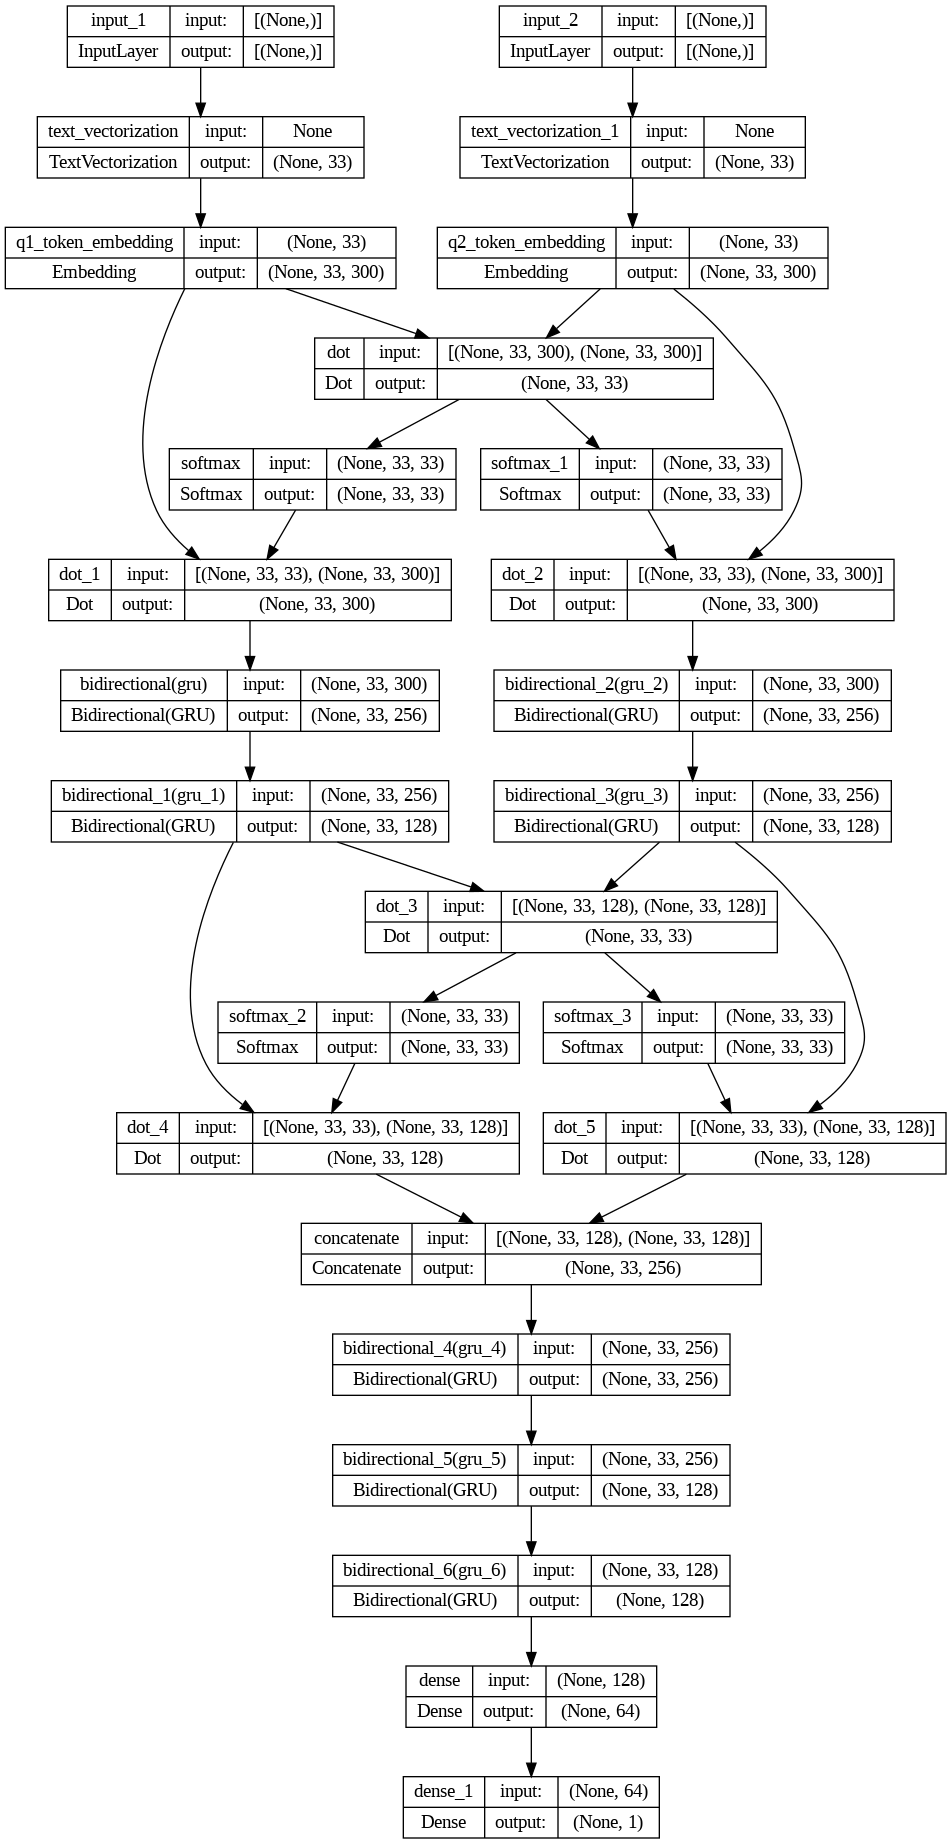

In [76]:
from tensorflow.keras.utils import plot_model
plot_model(model2,show_shapes=True)

In [77]:
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.2),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=['accuracy'])

In [78]:
# Early stopping
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print when the lr is reduced
                                                 min_lr=1e-7)

In [81]:
history2=model2.fit(train_token_dataset,
                    epochs=10,
                    validation_data=val_token_dataset,
                    validation_steps=int(0.2*len(val_token_dataset)),
                    callbacks=[reduce_lr,early_stopping])

Epoch 1/10
10739/10739 [==============================] - 361s 31ms/step - loss: 0.5628 - accuracy: 0.7607 - val_loss: 0.5434 - val_accuracy: 0.7774 - lr: 0.0010
Epoch 2/10
10739/10739 [==============================] - 326s 30ms/step - loss: 0.5300 - accuracy: 0.8019 - val_loss: 0.5348 - val_accuracy: 0.7927 - lr: 0.0010
Epoch 3/10
10739/10739 [==============================] - 326s 30ms/step - loss: 0.5116 - accuracy: 0.8240 - val_loss: 0.5433 - val_accuracy: 0.8001 - lr: 0.0010
Epoch 4/10
10739/10739 [==============================] - ETA: 0s - loss: 0.4947 - accuracy: 0.8435
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
10739/10739 [==============================] - 330s 31ms/step - loss: 0.4947 - accuracy: 0.8435 - val_loss: 0.5398 - val_accuracy: 0.8031 - lr: 0.0010
Epoch 5/10
10739/10739 [==============================] - 328s 31ms/step - loss: 0.4534 - accuracy: 0.8876 - val_loss: 0.5600 - val_accuracy: 0.8107 - lr: 2.0000e-04


In [84]:
model2.evaluate(val_token_dataset)

948/948 [==============================] - 13s 14ms/step - loss: 0.6073 - accuracy: 0.8077


[0.6073166728019714, 0.8076973557472229]

In [85]:
model2.evaluate(test_token_dataset)

948/948 [==============================] - 12s 13ms/step - loss: 0.6059 - accuracy: 0.8080


[0.605866551399231, 0.8079612255096436]

### Model 3: Token-Char GRUs

#### Creating Dataset pipeline

In [ ]:
train_data=tf.data.Dataset.from_tensor_slices((xtrain['question1'].values,
                                               xtrain['question2'].values,
                                               xtrain['charq1'].values,
                                               xtrain['charq2'].values))
train_labels=tf.data.Dataset.from_tensor_slices(ytrain.apply(pd.to_numeric).values)
train_dataset=tf.data.Dataset.zip((train_data,train_labels))
train_dataset=train_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)



val_data=tf.data.Dataset.from_tensor_slices((xval['question1'].values,
                                               xval['question2'].values,
                                             xval['charq1'].values,
                                             xval['charq2'].values))
val_labels=tf.data.Dataset.from_tensor_slices(yval.apply(pd.to_numeric).values)
val_dataset=tf.data.Dataset.zip((val_data,val_labels))
val_dataset=val_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)



test_data=tf.data.Dataset.from_tensor_slices((xtest['question1'].values,
                                               xtest['question2'].values,
                                              xtest['charq1'].values,
                                              xtest['charq2'].values))
test_labels=tf.data.Dataset.from_tensor_slices(ytest.apply(pd.to_numeric).values)
test_dataset=tf.data.Dataset.zip((test_data,test_labels))
test_dataset=test_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

#### Model

In [ ]:
q1_token_inputs=tf.keras.layers.Input(shape=(),dtype=tf.string)
q1_preprocessor=q1_text_vectorizer(q1_token_inputs)
q1_embed=q1_embedding(q1_preprocessor)
q1_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))(q1_embed)
q1_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh',return_sequences=True))(q1_gru1)
q1_token_model=tf.keras.Model(q1_token_inputs,q1_gru2)

q2_token_inputs=tf.keras.layers.Input(shape=(),dtype=tf.string)
q2_preprocessor=q2_text_vectorizer(q2_token_inputs)
q2_embed=q2_embedding(q2_preprocessor)
q2_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))(q2_embed)
q2_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh',return_sequences=True))(q2_gru1)
q2_token_model=tf.keras.Model(q2_token_inputs,q2_gru2)


q1_char_inputs=tf.keras.layers.Input(shape=(1,),dtype=tf.string)
q1_char_preprocessor=char_vectorizer_q1(q1_char_inputs)
q1_char_embed=char_embedding_q1(q1_char_preprocessor)
q1_char_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))(q1_char_embed)
q1_char_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh',return_sequences=True))(q1_char_gru1)
q1_char_model=tf.keras.Model(q1_char_inputs,q1_char_gru2)

q2_char_inputs=tf.keras.layers.Input(shape=(1,),dtype=tf.string)
q2_char_preprocessor=char_vectorizer_q2(q2_char_inputs)
q2_char_embed=char_embedding_q2(q2_char_preprocessor)
q2_char_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))(q2_char_embed)
q2_char_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh',return_sequences=True))(q2_char_gru1)
q2_char_model=tf.keras.Model(q2_char_inputs,q2_char_gru2)


q1_q2_token_concat=tf.keras.layers.Concatenate()([q1_token_model.output,
                               q2_token_model.output])

combined_token_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))(q1_q2_token_concat)
combined_token_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh',return_sequences=True))(combined_token_gru1)
combined_token_gru3=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh'))(combined_token_gru2)

q1_q2_char_concat=tf.keras.layers.Concatenate()([q1_char_model.output,
                               q2_char_model.output])

combined_char_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))(q1_q2_char_concat)
combined_char_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh',return_sequences=True))(combined_char_gru1)
combined_char_gru3=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh'))(combined_char_gru2)


token_char_concat=tf.keras.layers.Concatenate()([combined_token_gru3,
                               combined_char_gru3])


combined_dense1=tf.keras.layers.Dense(64,activation='relu')(token_char_concat)
output=tf.keras.layers.Dense(1,activation='sigmoid')(combined_dense1)

model3=tf.keras.Model(inputs=[q1_token_model.input,q2_token_model.input,q1_char_model.input,q2_char_model.input],
                      outputs=output,
                      name='Model3')

In [ ]:
model3.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model3,show_shapes=True)

In [ ]:
model3.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.2),
               optimizer=tf.keras.optimizers.Adam(lr=0.001),
               metrics=['accuracy'])

In [ ]:
history3=model3.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    validation_steps=int(0.2*len(val_dataset)))

In [ ]:
model3.evaluate(val_dataset)

2843/2843 [==============================] - 60s 21ms/step - loss: 0.5505 - accuracy: 0.7722


[0.550528883934021, 0.7721735835075378]

In [ ]:
model3.evaluate(test_dataset)

316/316 [==============================] - 21s 65ms/step - loss: 0.5389 - accuracy: 0.8023


[0.5389127135276794, 0.8023347854614258]